In [58]:
import numpy as np                             # viva numpy!
from scipy.integrate import RK45 as integrator # integrator | odeint / RK45
import matplotlib.pyplot as plt                # visualization util

In [138]:
def alpha_calc(q): # phi?
#     alpha = (1.5*np.pi - phi) - ( q[0] - q[1] )/2 # my calc
    
    # from Spong
#     alpha = ( q[0] - q[1] )/2 

    alpha = (2*np.pi) - ( q[0] + q[1] )/2
    
    return alpha

State-space: 
$$
    q = [ \theta, \ \dot \theta ]^T = [ \theta_{ns}, \theta_{s}, \ \dot \theta_{ns}, \dot \theta_{s} ]^T
$$

The swing stage equations of the robot similar to that of a frictionless double pendulum  can be written as :
$$
    M(\theta) \ddot \theta + N(\theta, \dot \theta) \dot \theta + \frac{1}{a} g(\dot \theta) = 0
$$

Normalazed peremeters $ \mu, \beta $ for matrixes:

$$
    M(\theta) =
    \begin{pmatrix}
        \beta^2 & -(1 + \beta) \beta \cos 2 \alpha \\
        -(1 + \beta) \beta \cos 2 \alpha & (1 + \beta)^2 (\mu + 1) + 1
    \end{pmatrix}
$$

In [110]:
def M(q, mu, beta, phi):
#     print(q[0], q[1], q[1], q[3])
    alpha = alpha_calc(q)
    M_11 = beta*beta
    M_12 = -(1+beta)*beta*np.cos(2*alpha)
    M_21 = M_12
    M_22 = (1+beta)*(1+beta)*(mu+1) + 1
    return np.array([[M_11, M_12],
                     [M_21, M_22]])

$$
    N(\theta, \dot \theta) =
    \begin{pmatrix}
        0 & (1 + \beta) \beta \dot \theta_{ns} sin(\theta_{s} - \theta_{ns}) \\
        -(1 + \beta) \beta \dot \theta_{ns} sin(\theta_{s} - \theta_{ns}) & 0
    \end{pmatrix}
$$

In [3]:
def N(q, mu, beta):
    N_11 = 0
    N_12 = (1+beta)*beta*q[2]*np.sin( q[3] - q[2] )
    N_21 = -N_12
    N_22 = 0
    return np.array([[N_11, N_12],
                     [N_21, N_22]])

$$
    g(\theta) =
    \begin{pmatrix}
        g \beta \sin \theta_{ns}  \\
        -( (\mu + 1)(1 + \beta) ) g \sin \theta_{s}
    \end{pmatrix}
$$

In [4]:
def g(q, mu, beta):
    _g_const = 9.81
    N_11 = _g_const * beta * np.sin( q[0] )
    N_21 = -( (mu + 1)*(1 + beta) ) * _g_const * np.sin( q[1] )
    return np.array([[N_11],
                     [N_21]])

$$
   - M(\theta) \ddot \theta =  N(\theta, \dot \theta) \dot \theta + \frac{1}{a} g(\dot \theta)
$$

Since $ \mu \in [0.1; 10] $ and $ \beta \in [0.1; 10] $, $ M(\theta)^{-1} $ exists, so

$$
     \ddot \theta = - M(\theta)^{-1} ( N(\theta, \dot \theta) \dot \theta + \frac{1}{a} g(\dot \theta) )
$$

Using $ z = \dot \theta $:

$$
    q = [\theta, z]
$$

$$
    \dot q = [z, - M(\theta)^{-1} ( N(\theta, z) z + \frac{1}{a} g(z) ) ]
$$

In [111]:
def W(q, mu, beta, phi):
    alpha = alpha_calc(q)
    
    Q_m = np.array([[-beta, -beta + ( mu*(1 + beta)*(1 + beta) + 2*(1 + beta)) * np.cos(2*alpha) ],
                    [0,     -beta]])
    
    Q_p = np.array([[beta*( beta - (1 + beta)*np.cos(2*alpha) ), (1 + beta)*( (1 + beta) - beta*np.cos(2*alpha) ) + 1 + mu*(1 + beta)*(1 + beta) ],
                    [beta*beta,     -beta]])
    
    H_a = np.linalg.inv(Q_p) @ Q_m
    
    J = np.array([[ 0, 1],
                  [-1, 0]])
    
    O = np.zeros([2, 2])
    
    return np.bmat([[J, O],
                    [O, H_a]])
#     return H_a

In [8]:
W([0.1, 0, 0.4, 0.1], mu=mu, beta=beta, phi=phi)

matrix([[ 0.        ,  1.        ,  0.        ,  0.        ],
        [-1.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        , -0.06323357, -1.28682502],
        [ 0.        ,  0.        , -0.06323357, -0.28682502]])

In [9]:
u = W([0.1, 0, 0.4, -0.1], mu=mu, beta=beta, phi=phi) @ np.asarray([[0.1, 0, 0.1, -0.1]]).T

In [10]:
u.T

matrix([[ 0.        , -0.1       ,  0.12235915,  0.02235915]])

In [11]:
np.asarray(u.T)[0] 

array([ 0.        , -0.1       ,  0.12235915,  0.02235915])

In [12]:
np.e

2.718281828459045

In [17]:
mu   = 2     # 0.1 ... 10
beta = 1     # 0.1 ... 10
phi  = 0.0034 # rad
l    = 1     # m

In [124]:
# Initial state vector

theta_ns_0 =  0.175    # swing leg   (ussually positive)
theta_s_0  = -0.175    # support leg
dot_theta_ns_0 = -0.2
dot_theta_s_0  =  0.15

In [14]:
np.pi/200

0.015707963267948967

In [112]:
def touch_detector(q, phi):
    alpha = alpha_calc(q)
    
    EPS = 0.05
    if abs(q[1] + alpha - 2*np.pi)<EPS : # a
#     if abs( (q[0] + q[1])/2 - phi )<EPS and ( abs(alpha)<EPS or (abs(alpha)-2*np.pi)<EPS ): # b
        return 1
    else:
        return 0

zero crossing at 2.5226242377492367
before:  [-0.16086761 -6.45104454  0.75815019  1.46275662]
after:  [-6.45104454  0.16086761 -0.18158027  1.28117635]
z:  [[-0.18158027]
 [ 1.28117635]]


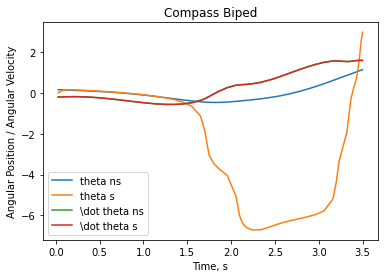

In [149]:
switch_flag = False
last_switch_time = -1.
def dyn_sys(t, x):
    global switch_flag, last_switch_time
#     print(x.T[0])
    q = x.T[0]
    
    if (switch_flag==False) and (t>2.5):
#     if touch_detector(q, phi) and (t - last_switch_time) > 0.0125:
        print("zero crossing at " + str(t))
        _W = W(q, mu=mu, beta=beta, phi=phi)
        
        print('before: ', q)
        q = (_W @ np.asarray([q]).T)
        q = np.asarray(q.T)[0]
        print('after: ', q)
        
        switch_flag = True
        last_switch_time = t
        
        w = M(q, mu=mu, beta=beta, phi=phi)
        _M_inv = np.linalg.inv( w )
        _N = N(q, mu=mu, beta=beta)
        _g = g(q, mu=mu, beta=beta)

        a_inv = (1+beta)/l

        z = np.array([[q[2]],
                      [q[3]]])
        z_dot = _M_inv @ ( _N @ z + a_inv*_g ) 
        
        print('z: ', z)

        return np.array([[z],
                         [z_dot]]).T
    else:
#         pass
        w = M(q, mu=mu, beta=beta, phi=phi)
        _M_inv = np.linalg.inv( w )
        _N = N(q, mu=mu, beta=beta)
        _g = g(q, mu=mu, beta=beta)

        a_inv = (1+beta)/l

        z = np.array([[q[2]],
                      [q[3]]])
        z_dot = _M_inv @ ( _N @ z + a_inv*_g ) 

        return np.array([[z],
                         [z_dot]]).T

t_upper = 3.5
t_lower = 0.
initial_state = np.array([theta_ns_0, theta_s_0, dot_theta_ns_0, dot_theta_s_0])

# x' = f(t, x)
solution = integrator(fun=dyn_sys, t0=t_lower, y0=initial_state, t_bound=t_upper, max_step=0.1, vectorized=True)

# collect data
t_values = []
q_ns_values = []
q_s_values  = []
q_ns_dot_values = []
q_s_dot_values  = []
alpha_values = [] 
test_values = []
zero_crossing_values = []
for i in range(1000):
    # get solution step state
    solution.step()
    
    # collect state stamps
    t_values.append(solution.t)
    q_ns_values.append(solution.y[0])
    q_s_values.append(solution.y[1])
    q_ns_dot_values.append(solution.y[2])
    q_s_dot_values.append(solution.y[2])
    
    # reconstruct alpha 
    alpha = alpha_calc(solution.y)
    alpha_values.append(alpha)
    
    # test record
    ttt = abs(solution.y[1] + alpha - 2*np.pi)
    test_values.append(ttt)
    
    # zero-crossing
    zcd = touch_detector(solution.y, phi)
    zero_crossing_values.append(zcd)
    
    # break loop when modeling is finished
    if solution.status == 'finished':
        break

plt.plot(t_values, q_ns_values, label='theta ns')
plt.plot(t_values, q_s_values,  label='theta s')
plt.plot(t_values, q_ns_dot_values, label='\dot theta ns')
plt.plot(t_values, q_s_dot_values,  label='\dot theta s')
# plt.plot(t_values, alpha_values, label='alpha')
# plt.plot(t, v_values, label='Velocity v')
plt.xlabel('Time, s')
plt.ylabel('Angular Position / Angular Velocity')
plt.legend()
plt.title('Compass Biped')
plt.show()

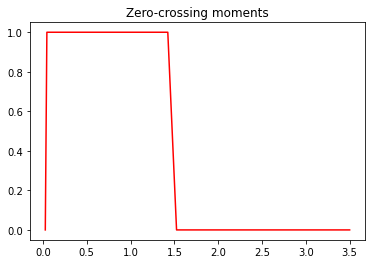

In [146]:
plt.plot(t_values, zero_crossing_values, 'r-')
plt.title('Zero-crossing moments')
plt.show()

0.002188268163976659


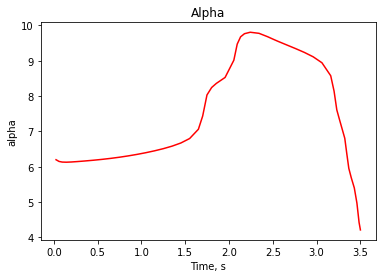

In [150]:
print(np.min(test_values))

plt.plot(t_values, alpha_values, 'r-')
# plt.plot(t_values, q_s_values,  'b-')
# plt.plot(t_values, test_values, 'g-')
plt.xlabel('Time, s')
plt.ylabel('alpha')
plt.title('Alpha')
plt.show()

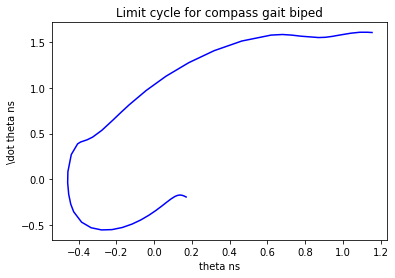

In [151]:
plt.plot(q_ns_values, q_ns_dot_values, 'b-')
plt.xlabel('theta ns')
plt.ylabel('\dot theta ns')
plt.title('Limit cycle for compass gait biped')
plt.show()

In [ ]:
f(0, np.array([1, 0, 0, 0]))

In [ ]:
x = np.array([1, 0, 0, 0])
_M_inv = np.linalg.inv( M(x, mu=mu, beta=beta, phi=phi) )
_N = N(x, mu=mu, beta=beta)
_g = g(x, mu=mu, beta=beta)

a_inv = (1+beta)/l

z = np.array([[x[2]],
              [x[3]]])
z_dot = _M_inv @ ( _N @ z + a_inv*_g ) 

In [ ]:
 np.linalg.inv( M(np.array([1, 0, 0.1, 0.1]), mu=mu, beta=beta, phi=phi) )

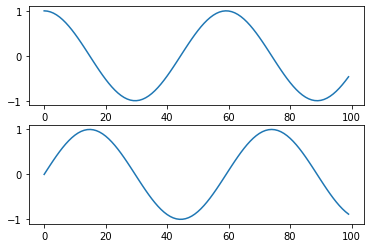

In [45]:
from IPython import display

plt.ion()

def plot_durations(y):
    plt.figure(2)
    plt.clf()
    plt.subplot(211)
    plt.plot(y[:,0])
    plt.subplot(212)
    plt.plot(y[:,1])

    if True: #is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())
        
x = np.linspace(-10,10,100)
y = []
for i in range(len(x)):
    y1 = np.cos(i/(3*3.14))
    y2 = np.sin(i/(3*3.14))
    y.append(np.array([y1,y2]))
    plot_durations(np.array(y))

plt.ioff() 
plt.close()

zero crossing at 0.05330242008031713
restarted at state:  [ 0.06845254 -0.1663078   0.01141823  0.21014876]
zero crossing at 0.18591448796491875
restarted at state:  [ 0.07546164 -0.07368581 -0.0085328   0.20861688]
zero crossing at 0.3137400204842173
restarted at state:  [ 0.0766612  -0.07613402 -0.00495453  0.1857424 ]
zero crossing at 0.43886717483591114
restarted at state:  [ 0.07804445 -0.07760362 -0.00476586  0.16340133]
zero crossing at 0.5684152795960233
restarted at state:  [ 0.07990457 -0.07889107 -0.00423443  0.13917153]
zero crossing at 0.6963856871854718
restarted at state:  [ 0.08172147 -0.08061791 -0.00363353  0.1149752 ]
zero crossing at 0.8239385972683526
restarted at state:  [ 0.08344406 -0.08231    -0.00300978  0.09126335]
zero crossing at 0.9507150473853593
restarted at state:  [ 0.08500242 -0.08391327 -0.00237031  0.0684038 ]
zero crossing at 1.0761015023791571
restarted at state:  [ 0.08625531 -0.08535988 -0.0017355   0.04702132]
zero crossing at 1.220856659942411

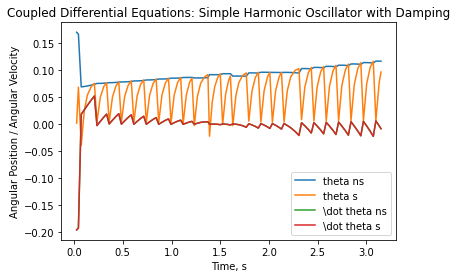

In [152]:
switch_flag = False
last_switch_time = -1.
def dyn_sys(t, x):
    global switch_flag, last_switch_time
#     print(x.T[0])
    q = x.T[0]
    
#     if (switch_flag==False) and (t>2.5) and (t<2.51):
    if touch_detector(q, phi) and (t - last_switch_time) > 0.125:
        print("zero crossing at " + str(t))
        
        switch_flag = True
        last_switch_time = t

        return q
    else:
        w = M(q, mu=mu, beta=beta, phi=phi)
        _M_inv = np.linalg.inv( w )
        _N = N(q, mu=mu, beta=beta)
        _g = g(q, mu=mu, beta=beta)

        a_inv = (1+beta)/l

        z = np.array([[q[2]],
                      [q[3]]])
        z_dot = _M_inv @ ( _N @ z + a_inv*_g ) 

        return np.array([[z],
                         [z_dot]]).T

t_upper = 3.15
t_lower = 0.
initial_state = np.array([theta_ns_0, theta_s_0, dot_theta_ns_0, dot_theta_s_0])

# x' = f(t, x)
# solution = integrator(fun=dyn_sys, t0=t_lower, y0=initial_state, t_bound=t_upper, max_step=0.1, vectorized=True)

# collect data
t_values = []
q_ns_values = []
q_s_values  = []
q_ns_dot_values = []
q_s_dot_values  = []
alpha_values = [] 
test_values = []
zero_crossing_values = []

solution = integrator(fun=dyn_sys, t0=t_lower, y0=initial_state, t_bound=t_upper, max_step=0.1, vectorized=True)
while True:
    # get solution step state
    solution.step()
    
    # collect state stamps
    t_values.append(solution.t)
    q_ns_values.append(solution.y[0])
    q_s_values.append(solution.y[1])
    q_ns_dot_values.append(solution.y[2])
    q_s_dot_values.append(solution.y[2])
    
    # reconstruct alpha 
    alpha = alpha_calc(solution.y)
    alpha_values.append(alpha)
    
    # test record
    ttt = abs(solution.y[1] + alpha - 2*np.pi)
    test_values.append(ttt)
    
    # zero-crossing
    zcd = touch_detector(solution.y, phi)
    zero_crossing_values.append(zcd)
    
    # restart solver on discontinious region
    if switch_flag == True:
        q = solution.y
        _W = W(q, mu=mu, beta=beta, phi=phi)
        q = (_W @ np.asarray([q]).T)
        q = np.asarray(q.T)[0]
        
#         print('is it? ', q)
        
        solution = integrator(fun=dyn_sys, t0=solution.t, y0=q, t_bound=t_upper, max_step=0.25, vectorized=True)
        
        switch_flag = False
        print('restarted at state: ', q)
#         break

    # break loop if solution is unstable
    if np.linalg.norm( solution.y ) > 180:
        break
        
    # break loop when modeling is finished
    if solution.status == 'finished':
        break

print( np.linalg.norm( solution.y ) ) 

plt.plot(t_values, q_ns_values, label='theta ns')
plt.plot(t_values, q_s_values,  label='theta s')
plt.plot(t_values, q_ns_dot_values, label='\dot theta ns')
plt.plot(t_values, q_s_dot_values,  label='\dot theta s')
# plt.plot(t_values, alpha_values, label='alpha')
# plt.plot(t, v_values, label='Velocity v')
plt.xlabel('Time, s')
plt.ylabel('Angular Position / Angular Velocity')
plt.legend()
plt.title('Coupled Differential Equations: Simple Harmonic Oscillator with Damping')
plt.show()

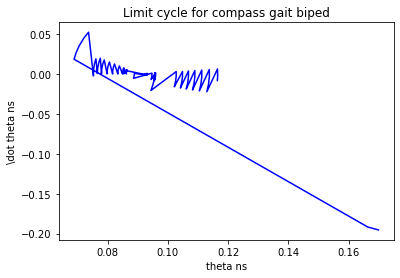

In [153]:
plt.plot(q_ns_values, q_ns_dot_values, 'b-')
plt.xlabel('theta ns')
plt.ylabel('\dot theta ns')
plt.title('Limit cycle for compass gait biped')
plt.show()